### Imports

In [1]:
# Imports
# -----------------------
# general
# -----------------------
import os
import numpy as np
import matplotlib.pyplot as plt
# -----------------------
# Gymnasium
# -----------------------
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding

# -----------------------
# Stable Baselines 3
# -----------------------
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

### Demand Generator
Generate Smooth demand funtion form discrete demenad
will be used to sample demand by the Environment

In [2]:
##########################################
# Generate demand for the environment
##########################################
hourly_demand = np.array([2, 2, 2, 2, 3, 5, 10, 12, 10, 8, 6, 5, 5, 5, 5, 6, 7, 9, 10, 9, 6, 4, 3, 2])

class DemandGenerator:
    def __init__(self, hourly_demand=hourly_demand, seed=None, noise_std=1):
        """
        - hourly_demand: The demand values over steps.
        - seed: Seed for reproducibility.
        - noise_std: std of Gaussian noise.
        """
        if seed is not None:
            np.random.seed(seed)
        
        # Ensure periodicity: first and last demand values must be the same.
        assert hourly_demand[0] == hourly_demand[-1], "First and last demand values must be the same."
        
        self.x = np.array(range(len(hourly_demand)))
        self.y = np.array(hourly_demand)
        self.spline = CubicSpline(self.x, self.y, bc_type='periodic')
        self.noise_std = noise_std

    def __call__(self, t):
        """
        Returns the demand at time 't' with Gaussian noise.

        Params:
        - t: The time step at which to evaluate demand (can be np.array).

        Returns:
        - float: Demand value at time 't' with noise.
        """
        if isinstance(t, np.ndarray):
            return np.array([self.__call__(ti) for ti in t])
        base_demand = self.spline(t)
        noise = np.random.normal(0, self.noise_std)
        # Ensure non-negative demand
        return max(0, base_demand + noise)

As seen, we have constructed a smooth demand function from the initial demand data points defined above.

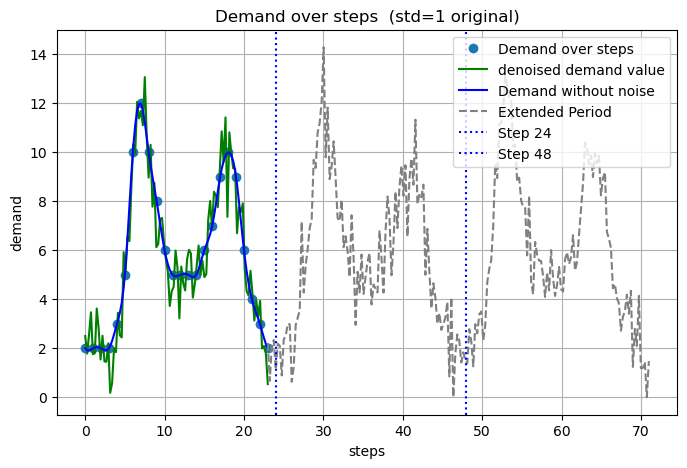

In [3]:
from scipy.interpolate import CubicSpline

sample_demad = DemandGenerator(hourly_demand, seed = 42, noise_std=1)
sample_demad_clean = DemandGenerator(hourly_demand, seed = 42, noise_std=0)
x = np.array(range(len(hourly_demand)))
y = hourly_demand


# Values for plotting
x_smooth = np.linspace(x[0], x[-1], 24 * 4)
y_smooth = sample_demad(x_smooth)
y_smooth_clean = sample_demad_clean(x_smooth)
x_extra = np.linspace(x[-1], x[-1] + 48, 48 * 4)
y_extra = sample_demad(x_extra)



# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'o', label="Demand over steps")  # Original points
plt.plot(x_smooth, y_smooth, color='green', label="denoised demand value")  # Interpolated curve
plt.plot(x_smooth, y_smooth_clean, color='blue', label="Demand without noise")
plt.plot(x_extra, y_extra, '--', color='gray', label="Extended Period")  # Extended view

plt.axvline(x=24, color='blue', linestyle='dotted', label="Step 24")
plt.axvline(x=48, color='blue', linestyle='dotted', label="Step 48")

plt.xlabel("steps")
plt.ylabel("demand")
plt.legend(loc='upper right')
plt.title("Demand over steps  (std=1 original)")
plt.grid()
plt.show()



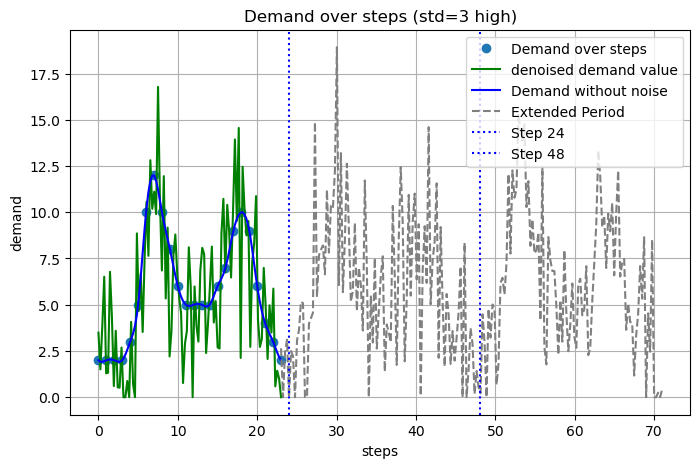

In [4]:
from scipy.interpolate import CubicSpline

sample_demad = DemandGenerator(hourly_demand, seed = 42, noise_std=3)
sample_demad_clean = DemandGenerator(hourly_demand, seed = 42, noise_std=0)
x = np.array(range(len(hourly_demand)))
y = hourly_demand


# Values for plotting
x_smooth = np.linspace(x[0], x[-1], 24 * 4)
y_smooth = sample_demad(x_smooth)
y_smooth_clean = sample_demad_clean(x_smooth)
x_extra = np.linspace(x[-1], x[-1] + 48, 48 * 4)
y_extra = sample_demad(x_extra)



# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'o', label="Demand over steps")  # Original points
plt.plot(x_smooth, y_smooth, color='green', label="denoised demand value")  # Interpolated curve
plt.plot(x_smooth, y_smooth_clean, color='blue', label="Demand without noise")
plt.plot(x_extra, y_extra, '--', color='gray', label="Extended Period")  # Extended view

plt.axvline(x=24, color='blue', linestyle='dotted', label="Step 24")
plt.axvline(x=48, color='blue', linestyle='dotted', label="Step 48")

plt.xlabel("steps")
plt.ylabel("demand")
plt.legend(loc='upper right')
plt.title("Demand over steps (std=3 high)")
plt.grid()
plt.show()



# Price Generator


In [5]:
##########################################
# Generate Prices (reward) for the environment
##########################################

# Price A : 1 with 0.25 std
# Price B : 2 with 0.25 std
# Price function is base ** purchase _amount, cliped at Penalty_Price
# Penalty_Price = (2 * max(price_A, Price_B)) ** Max_water_level

def get_penalty_price(max_water_level, base_price_A, base_price_B, exponent=2):
    return 2 * ((max_water_level ** exponent) * max(base_price_A, base_price_B))

class PriceGenerator:
    """
    Generate prices for water from two sources with Gaussian noise,
    price = (amount ** 2) * (base_price + Gaussian noise)
    """
    def __init__(self, base_price_A=1, base_price_B=2, max_water_level=20, seed=None, noise_std=1):
        self.EXPONENT = 2
        self.base_price_A = base_price_A
        self.base_price_B = base_price_B
        # base prices + 1 so that the multiplier is always > 1.
        self.penalty_price = get_penalty_price(max_water_level, base_price_A, base_price_B, exponent=self.EXPONENT)
        self.noise_std = noise_std
        if seed is not None:
            np.random.seed(seed)
        
    def __call__(self, amount_from_A, amount_from_B):
        price_A = (amount_from_A ** self.EXPONENT) * max(0, np.random.normal(self.base_price_A, self.noise_std))
        price_B = (amount_from_B ** self.EXPONENT) * max(0, np.random.normal(self.base_price_B, self.noise_std))
        # Adding Gaussian noise
        noisy_price_A = max(0, np.random.normal(price_A, self.noise_std))
        noisy_price_B = max(0, np.random.normal(price_B, self.noise_std))
        # Clipping to penalty price
        
        expense = noisy_price_A + noisy_price_B
        expense = min(expense, self.penalty_price)
        return expense

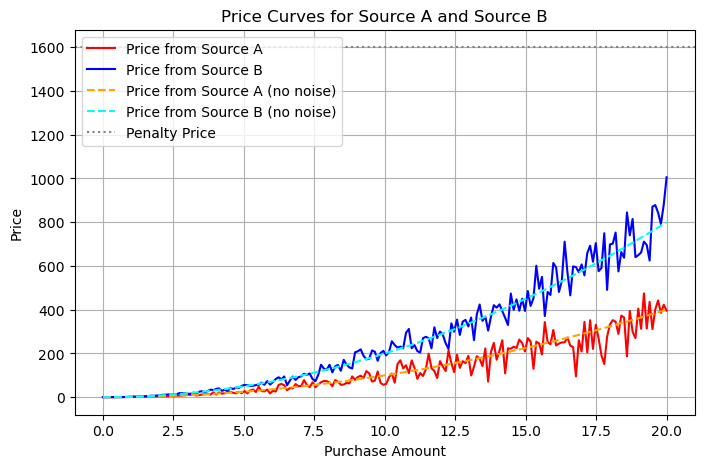

In [6]:
import numpy as np
import matplotlib.pyplot as plt


# Create an instance with a fixed seed for reproducibility
price_gen = PriceGenerator(seed=42, noise_std=0.25)
price_gen_no_noise = PriceGenerator(seed=42, noise_std=0)

# Generate an array of purchase amounts from 0 to 20
purchase_amounts = np.linspace(0, 20, 200)

# Compute prices when buying only from Source A (amount_from_B = 0)
prices_source_A = [price_gen(amount, 0) for amount in purchase_amounts]

# Compute prices when buying only from Source B (amount_from_A = 0)
prices_source_B = [price_gen(0, amount) for amount in purchase_amounts]

prices_source_A_no_noise = [price_gen_no_noise(amount, 0) for amount in purchase_amounts]
prices_source_B_no_noise = [price_gen_no_noise(0, amount) for amount in purchase_amounts]

# Plot both curves on a single plot
plt.figure(figsize=(8, 5))
plt.plot(purchase_amounts, prices_source_A, label="Price from Source A", color='red')
plt.plot(purchase_amounts, prices_source_B, label="Price from Source B", color='blue')

plt.plot(purchase_amounts, prices_source_A_no_noise, label="Price from Source A (no noise)", color='orange', linestyle='dashed')
plt.plot(purchase_amounts, prices_source_B_no_noise, label="Price from Source B (no noise)", color='cyan', linestyle='dashed')
plt.axhline(y=price_gen.penalty_price, color='gray', linestyle='dotted', label="Penalty Price")

plt.xlabel("Purchase Amount")
plt.ylabel("Price")
plt.title("Price Curves for Source A and Source B")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


### reward function
The reward function is the expense function, when meeting the water demand
If not meeting the water demand, pay for each missed water units a steep rate of penalty:


In [7]:
class RewardGenerator:
    def __init__(self,noise_std=0.25,seed=42, base_price_A=1, base_price_B=2, max_water_level=20):
        self.price_gen = PriceGenerator(seed=seed, noise_std=noise_std, base_price_A=base_price_A, base_price_B=base_price_B, max_water_level=max_water_level)
        self.penalty_per_unit = get_penalty_price(max_water_level, base_price_A, base_price_B)

    def __call__(self, water_level, demand, amount_from_A, amount_from_B):
        # return tuple: reward, expense+penalty
        expense = self.price_gen(amount_from_A, amount_from_B)
        
        # Calculate unmet demand ands penalty
        unmet_demand = max(0, demand - water_level)
        penalty = unmet_demand * self.penalty_per_unit

        # Final reward
        # Normalized reward, in terms of missed demand
        reward = -(expense + penalty) / self.penalty_per_unit 
        return reward, (expense + penalty)



### Calcualte new water level

In [8]:
class WaterLevelGenerator:
    def __init__(self, max_water_level=20):
        self.max_water_level = max_water_level

    def __call__(self, water_level, demand, amount_from_A, amount_from_B):
        water_level = max(0, water_level - demand)
        water_level = min(water_level + amount_from_A + amount_from_B, self.max_water_level)
        return water_level


## The Environment definition

In [9]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from gymnasium.utils import seeding

# ====================================================
# Global Constants
# ====================================================
# Environment settings
MAX_CYCLES_DEFAULT = 10       # Default number of days (cycles)
TIME_STEPS_PER_DAY = 10       # Number of discrete time steps per day
MAX_WATER_LEVEL = 20          # Maximum water capacity

# Demand generation constants
NOISE_STD_DEMAND = 1    
NOISE_STD_PRICE = 0.25

# ====================================================
# Mini Water Supply Environment
# ====================================================
class MiniWaterSupplyEnv(gym.Env):

    def __init__(self, max_cycles=MAX_CYCLES_DEFAULT):
        super(MiniWaterSupplyEnv, self).__init__()
        
        # Set environment parameters
        self.max_cycles = max_cycles                  # Total cycles (days)
        self.time_steps_per_day = TIME_STEPS_PER_DAY  # Discrete time steps per day
        self.max_water_level = MAX_WATER_LEVEL        # Maximum water capacity
        

        # Define observation space: 
        # [current water level, current demand, current time step]
        obs_low=np.array([0.0, 0.0, 0.0])
        obs_high=np.array([self.max_water_level, np.inf, self.time_steps_per_day - 1])
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float64)
        
        # define action space: amount to buy, from 0 up to MAX_WATER_LEVEL
        low = np.array([0, 0])
        high = np.array([self.max_water_level, self.max_water_level])
        self.action_space = spaces.Box(low=low, high=high, dtype=np.float64)
        
        # logs to save demand met percentage
        # update each step, append True if demand met, False otherwise        
        self.reset()
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return seed
    
    def reset(self, noise_std_demand=NOISE_STD_DEMAND, noise_std_price=NOISE_STD_PRICE, seed=None, options=None):
        
        super().reset(seed=seed)
        self.seed(seed=seed)

        noise_std_demand = options.get('noise_std_demand', NOISE_STD_DEMAND) if options else NOISE_STD_DEMAND
        noise_std_price = options.get('noise_std_price', NOISE_STD_PRICE) if options else NOISE_STD_PRICE

        # Usage: self.get_demand(current_time_step)
        self.get_demand = DemandGenerator(seed=seed, noise_std=noise_std_demand)
        
        # Usage: self.get_reward(water_level, demand, amount_from_A, amount_from_B)
        self.get_reward = RewardGenerator(seed=seed, noise_std=noise_std_price)

        # Usage: self.get_new_water_level(water_level, demand, amount_from_A, amount_from_B)
        self.get_new_water_level = WaterLevelGenerator(max_water_level=MAX_WATER_LEVEL)
        
        self.current_cycle = 0
        self.current_time_step = 0
        #start with random water level (0 to max_water_level, int)
        self.water_level = self.np_random.integers(0, self.max_water_level + 1)
        self.demand = self.get_demand(self.current_time_step)
        self.expense = 0
        self.total_reward = 0
        self.demand_met = []


        return self._get_obs(), self._get_info()
    
    def step(self, action):
        """
        Perform one time step in the environment.

        Args:
            action (fromA,fromB)
            
        Returns:
            observation: [water_level, demand, current_time_step]
            reward (float): The reward (negative cost/penalty).
            terminated (bool): Whether the episode has ended.
            truncated (bool): Always False.
            info (dict): Additional information.
        """
        # Ensure action is an integer and within the allowed range.
        if action.shape == (1,2): # Batched
            action = action[0]
        action = np.array(action)
        from_A, from_B = action[0], action[1]
        assert from_A >= 0 and from_A <= self.max_water_level
        assert from_B >= 0 and from_B <= self.max_water_level

        # Check if demand is met this step: True: demand met, False: demand not met 
        self.demand_met = self.water_level >= self.demand

        # Calcualte Reward
        reward, expense = self.get_reward(self.water_level, self.demand, from_A, from_B)

        # Calculate new water level
        new_water_level = self.get_new_water_level(self.water_level, 
                                                   self.demand, from_A,
                                                   from_B)
        # Update environment state.
        self.water_level = new_water_level
        self.expense = expense
        
        # Advance the time step
        self.current_time_step += 1
        if self.current_time_step >= self.time_steps_per_day:
            self.current_cycle += 1
            self.current_time_step = 0
        # Update demand and check if the episode is terminated.
        self.demand= self.get_demand(self.current_time_step)
        if self.current_cycle >= self.max_cycles:
            terminated = True
        else:
            terminated = False
        
        self.total_reward += reward

        # Return: (observation, reward, terminated, truncated, info)
        return self._get_obs(), reward, terminated, False, self._get_info()

    
    def _get_obs(self):
        return np.array([self.water_level, self.demand, self.current_time_step], dtype=np.float64)
    
    def _get_info(self):
        return {
            "water_level": self.water_level,
            "demand": self.demand,
            "current_time_step": self.current_time_step,
            "current_cycle": self.current_cycle,
            "expense": self.expense,
            "total_reward": self.total_reward,
            "demand_met": self.demand_met
        }
    

    def set_state(self, water_level, demand, current_time_step, current_cycle, total_reward=None):
        # assert legitimate values
        assert water_level >= 0 and water_level <= self.max_water_level
        assert demand >= 0
        assert current_time_step >= 0 and current_time_step < self.time_steps_per_day
        assert current_cycle >= 0 and current_cycle < self.max_cycles
        
        # set state
        self.water_level = water_level
        self.demand = demand
        self.current_time_step = current_time_step
        self.current_cycle = current_cycle
        self.total_reward = self.total_reward if total_reward is None else total_reward
    
    def render(self, mode='human'):
        """
        Render the current state.
        """
        info = self._get_info()
        print(info)


### Test the Environment

In [10]:
from gymnasium.utils.env_checker import check_env
# Create the environment
env = MiniWaterSupplyEnv(max_cycles=2)
# Check the environment
check_env(env, warn=True)

c:\Users\eranw\miniconda3\envs\filo\Lib\site-packages\gymnasium\utils\env_checker.py:367: UserWarning: WARN: `check_env(warn=...)` parameter is now ignored.
  logger.warn("`check_env(warn=...)` parameter is now ignored.")
c:\Users\eranw\miniconda3\envs\filo\Lib\site-packages\gymnasium\utils\env_checker.py:333: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(
c:\Users\eranw\miniconda3\envs\filo\Lib\site-packages\gymnasium\utils\env_checker.py:315: UserWarning: WARN: A Box observation space maximum value is infinity. This is probably too high.
  logger.warn(
c:\Users\eranw\miniconda3\envs\filo\Lib\site-packages\gymnasium\utils\env_checker.py:276: UserWarning: WARN: Official support for the `seed` function is dropped. Standard practice is to reset gymnasium environments using `env.reset(seed=<desired seed>)`


In [11]:
# ====================================================
# Create and test the environment
# ====================================================
env = MiniWaterSupplyEnv(max_cycles=1)
print("action space:\n", env.action_space)
print("observation space:\n", env.observation_space)
print()
obs, info = env.reset(seed=42)
env.action_space.seed(42) # Seed the "env.action_space.sample()"
print(f"obs:\n{obs} \ninfo:\n{info}")

env.set_state(10, 5, 0, 0)
env.render()

print("=" * 100)
# test random steps
for i in range(20): # will only show 10 as max_cycles=1
    action = env.action_space.sample()
    action = np.array([0,0])
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Action: {action}")
    print(f"step {i}:\nobs:\n{obs}\nreward:\n{reward}\ninfo:\n{info}")
    if terminated:
        break

action space:
 Box(0.0, 20.0, (2,), float64)
observation space:
 Box(0.0, [20. inf  9.], (3,), float64)

obs:
[1.         2.49671415 0.        ] 
info:
{'water_level': 1, 'demand': 2.496714153011233, 'current_time_step': 0, 'current_cycle': 0, 'expense': 0, 'total_reward': 0, 'demand_met': []}
{'water_level': 10, 'demand': 5, 'current_time_step': 0, 'current_cycle': 0, 'expense': 0, 'total_reward': 0, 'demand_met': []}
Action: [0 0]
step 0:
obs:
[5.         1.76586304 1.        ]
reward:
-0.00023797341506375395
info:
{'water_level': 5, 'demand': 1.7658630430508195, 'current_time_step': 1, 'current_cycle': 0, 'expense': 0.38075746410200634, 'total_reward': -0.00023797341506375395, 'demand_met': True}
Action: [0 0]
step 1:
obs:
[3.23413696 1.53658231 2.        ]
reward:
-8.477500681030697e-05
info:
{'water_level': 3.2341369569491807, 'demand': 1.5365823071875377, 'current_time_step': 2, 'current_cycle': 0, 'expense': 0.13564001089649116, 'total_reward': -0.00032274842187406095, 'demand_m

## Wrappers

In [12]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces

### Normalize Observations

In [13]:
class NormalizedObservationWrapper(gym.ObservationWrapper):
    """
    Normalizes the observation [water_level, demand, time_step] to [0,1]^3.
    Assumes:
      - water_level in [0, max_water_level]
      - demand is clipped to [0, max_water_level]
      - time_step in [0, time_steps_per_day - 1]
    """
    def __init__(self, env):
        super(NormalizedObservationWrapper, self).__init__(env)
        self.max_water_level = env.max_water_level
        self.time_steps_per_day = env.time_steps_per_day
        # Set the new observation space to [0,1]^n
        self.observation_space = spaces.Box(low=0.0, high=1.0,
                                            shape=env.observation_space.shape,
                                            dtype=np.float32)
    
    def observation(self, obs):
        water_level, demand, time_step = obs
        norm_water = water_level / self.max_water_level
        # Clip demand to max_water_level before normalizing
        norm_demand = min(demand, self.max_water_level) / self.max_water_level
        norm_time = time_step / (self.time_steps_per_day - 1) if self.time_steps_per_day > 1 else 0.0
        return np.array([norm_water, norm_demand, norm_time], dtype=np.float32)


### Normalize Actions

In [14]:

class NormalizedActionWrapper(gym.ActionWrapper):
    """
    Normalizes the continuous action space to [0,1].
    Original actions: each in [0, max_water_level]
    Normalized actions: each in [0,1]
    """
    def __init__(self, env):
        super(NormalizedActionWrapper, self).__init__(env)
        self.max_water_level = env.max_water_level
        act_shape = env.action_space.shape
        self.action_space = spaces.Box(low=0.0, high=1.0,
                                       shape=act_shape,
                                       dtype=np.float32)
    
    def action(self, action):
        # action: is normalized to [0,1]
        # Denormalize the action: from normalized [0,1] to original scale.
        return action * self.max_water_level
    

### Discretisize Observations

In [15]:

class DiscreteObservationWrapper(gym.ObservationWrapper):
    """
    Discretizes normalized observations into a single discrete value.
    
    Assumes the observation space is normalized to [0,1] for each dimension.
    Each dimension is divided into `num_bins` bins.
    """
    def __init__(self, env, num_bins=10):
        super(DiscreteObservationWrapper, self).__init__(env)
        self.num_bins = num_bins
        # observation space is a Box
        obs_shape = env.observation_space.shape
        self.obs_dims = obs_shape[0]
        # Total discrete states = num_bins ** obs_dims
        self.observation_space = spaces.Discrete(num_bins ** self.obs_dims)

    def observation(self, obs):
        # Calculate multi discrete indices for each dimension.
        discrete_indices = np.floor(obs * self.num_bins).astype(int)
        discrete_indices = np.clip(discrete_indices, 0, self.num_bins - 1)
        
        # Compose into a single discrete index.
        powers = self.num_bins ** np.arange(self.obs_dims)
        index = int(np.dot(discrete_indices, powers)) ## should already be int
        return index
    
    

### Discretisize Actions

In [16]:
class DiscreteActionToActions():
    def __init__(self, num_bins=20):
        self.num_bins = num_bins
    def __call__(self, action):
        return action % self.num_bins, action // self.num_bins

In [17]:

class DiscreteActionWrapper(gym.ActionWrapper):
    """
    Discretizes normalized actions into a single discrete value.
    
    Action Space is a Box normalized to [0,1] per dimension.
    The wrapper converts a single discrete integer into a continuous action by:
      1. Converting the integer to multi-dimensional bin indices.
      2. Mapping each index to the corresponding bin center.
    The new action space is Discrete(num_bins**act_dims).
    """
    def __init__(self, env, num_bins=11):
        super(DiscreteActionWrapper, self).__init__(env)
        self.num_bins = num_bins # include a bin for 0
        act_shape = env.action_space.shape
        self.act_dims = act_shape[0] ## 2
        # New action space: one discrete integer in [0, (num_bins^act_dims) - 1]
        self.action_space = spaces.Discrete(num_bins ** self.act_dims)
    
    def action(self, action):
        # Given a discrete integer, recover multi-dimensional indices.
        discrete_indices = np.array([
            action % self.num_bins,
            action // self.num_bins
        ])
        # map each discrete index to its continuous value (bin center).
        continuous_action = np.array([(idx) / self.num_bins for idx in discrete_indices],
                                       dtype=np.float32)
        return continuous_action


### Decalaring Environments for each algorithms

In [18]:
cycles = 3
bins = 20

In [19]:


# ---------------------------------------------
envDQN = MiniWaterSupplyEnv(max_cycles=cycles)
envDQN = NormalizedObservationWrapper(envDQN)
envDQN = NormalizedActionWrapper(envDQN)

envA2C = MiniWaterSupplyEnv(max_cycles=cycles)
envA2C = NormalizedObservationWrapper(envA2C)
envA2C = NormalizedActionWrapper(envA2C)

envSAC = MiniWaterSupplyEnv(max_cycles=cycles)
envSAC = NormalizedObservationWrapper(envSAC)
envSAC = NormalizedActionWrapper(envSAC)

envPPO = MiniWaterSupplyEnv(max_cycles=cycles)
envPPO = NormalizedObservationWrapper(envPPO)
envPPO = NormalizedActionWrapper(envPPO)
# -----------------------------

# DQN
envDQN = DiscreteObservationWrapper(envDQN, num_bins=bins)
envDQN = DiscreteActionWrapper(envDQN, num_bins=bins)
# -----------------------------





### Wrapper for logging more metrics for our results

In [20]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class WaterSupplyMetricCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.demand_met_list = []  # Accumulate is demand met for each step
        self.expense_list = []  # Accumulate expense for each step

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        if infos and "demand_met" in infos[0]:
            self.demand_met_list.append(infos[0]["demand_met"])
        if infos and "expense" in infos[0]:
            self.expense_list.append(infos[0]["expense"])

        # Check if the episode is done
        dones = self.locals.get("dones", None)
        if dones is not None and dones[0]:
            # Compute the percentage of steps where demand was met
            if self.demand_met_list:
                percentage = np.mean(self.demand_met_list)
                self.logger.record("train/avg_demand_met", percentage)
            # Reset the accumulator for the next episode
            self.demand_met_list = []

            if self.expense_list:
                total_expense = np.sum(self.expense_list)
                self.logger.record("train/total_expense", total_expense)
            # Reset the accumulator for the next episode
            self.expense_list = []
        return True

callback_metric = WaterSupplyMetricCallback()

### Training


In [21]:
from stable_baselines3 import DQN
from stable_baselines3 import A2C
from stable_baselines3 import SAC
from stable_baselines3 import PPO


#### DQN

In [22]:
modelDQN = DQN("MlpPolicy", envDQN, verbose=1, seed=42, tensorboard_log="./tb_logs/DQN/")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


#### A2C

In [23]:
modelA2C = A2C("MlpPolicy", envA2C, verbose=1, seed=42, tensorboard_log="./tb_logs/A2C/")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


#### SAC

In [24]:
modelSAC = SAC("MlpPolicy", envSAC, verbose=1, seed=42, tensorboard_log="./tb_logs/SAC/")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


#### PPO


In [25]:
modelPPO = PPO("MlpPolicy", envPPO, verbose=1, seed=42, tensorboard_log="./tb_logs/PPO/")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### train

In [26]:
# time_steps = 200000

In [27]:
# # DQN
# modelDQN.learn(total_timesteps=time_steps, callback=callback_metric)

In [28]:
# # A2C
# modelA2C.learn(total_timesteps=time_steps, callback=callback_metric)

In [29]:
# # SAC
# modelSAC.learn(total_timesteps=time_steps, callback=callback_metric)

In [30]:
# # PPO
# modelPPO.learn(total_timesteps=time_steps, callback=callback_metric)

In [31]:
# # Save the models to disk
# modelDQN.save("models/DQN_model")
# modelA2C.save("models/A2C_model")
# modelSAC.save("models/SAC_model")
# modelPPO.save("models/PPO_model")

### Evaluate the models

In [32]:
def evaluate_expense(model, env, n_eval_episodes=100, render=False, discrete_action=False, demand_std=None):
    """
    Evaluates a model: the mean and std of the total expense

        n_eval_episodes: Number of episodes to evaluate over.

    Returns:
        mean_expense: over episodes.
        std_expense:  over episodes.
        ratio: of buying from A vs from B.
    """
    expenses = []
    amount_from_A = 0
    amount_from_B = 0
    for episode in range(n_eval_episodes):
        if demand_std == None:
            obs, info = env.reset()
        else:
            obs, info = env.reset(options={'noise_std_demand': demand_std})
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            if render:
                env.render()
            expenses.append(info['expense'])
            if not discrete_action: 
                # can you the values directly
                amount_from_A += action[0]
                amount_from_B += action[1]
            else:
                # convert to values
                a,b = DiscreteActionToActions(num_bins=20)(action)
                amount_from_A += a
                amount_from_B += b
    
    mean_expense = np.mean(expenses)
    std_expense = np.std(expenses)
    return mean_expense, std_expense,(amount_from_A / (amount_from_B+1e-16))

In [33]:
# Evaluate the models
modelDQN = DQN.load("models/DQN_model")
modelA2C = A2C.load("models/A2C_model")
modelSAC = SAC.load("models/SAC_model")
modelPPO = PPO.load("models/PPO_model")
n_eval_episodes = 1000

mean_rewardDQN, std_rewardDQN, ABRationDQN = evaluate_expense(modelDQN, envDQN, n_eval_episodes=n_eval_episodes, discrete_action=True)
mean_rewardA2C, std_rewardA2C, ABRationA2C = evaluate_expense(modelA2C, envA2C, n_eval_episodes=n_eval_episodes)
mean_rewardSAC, std_rewardSAC, ABRationSAC = evaluate_expense(modelSAC, envSAC, n_eval_episodes=n_eval_episodes)
mean_rewardPPO, std_rewardPPO, ABRatioPPO = evaluate_expense(modelPPO, envPPO, n_eval_episodes=n_eval_episodes)

In [34]:
print("Models Evaluation:")
print(f"DQN: Mean Expense: {mean_rewardDQN:.2f} +/- {std_rewardDQN:.2f}, A/B Ratio: {ABRationDQN:.2f}")
print(f"A2C: Mean Expense: {mean_rewardA2C:.2f} +/- {std_rewardA2C:.2f}, A/B Ratio: {ABRationA2C:.2f}")
print(f"SAC: Mean Expense: {mean_rewardSAC:.2f} +/- {std_rewardSAC:.2f}, A/B Ratio: {ABRationSAC:.2f}")
print(f"PPO: Mean Expense: {mean_rewardPPO:.2f} +/- {std_rewardPPO:.2f}, A/B Ratio: {ABRatioPPO:.2f}")

Models Evaluation:
DQN: Mean Expense: 45.85 +/- 184.02, A/B Ratio: 1.76
A2C: Mean Expense: 112.47 +/- 245.58, A/B Ratio: 106107629069536919552.00
SAC: Mean Expense: 33.59 +/- 169.49, A/B Ratio: 1.66
PPO: Mean Expense: 83.75 +/- 214.31, A/B Ratio: 94742966918200262656.00


### Robustness test

In [35]:
mean_rewardDQN_robust, std_rewardDQN_robust, ABRationDQN_robust = evaluate_expense(modelDQN, envDQN, n_eval_episodes=n_eval_episodes, discrete_action=True, demand_std=3)
mean_rewardA2C_robust, std_rewardA2C_robust, ABRationA2C_robust = evaluate_expense(modelA2C, envA2C, n_eval_episodes=n_eval_episodes, demand_std=3)
mean_rewardSAC_robust, std_rewardSAC_robust, ABRationSAC_robust = evaluate_expense(modelSAC, envSAC, n_eval_episodes=n_eval_episodes, demand_std=3)
mean_rewardPPO_robust, std_rewardPPO_robust, ABRatioPPO_robust = evaluate_expense(modelPPO, envPPO, n_eval_episodes=n_eval_episodes, demand_std=3)

In [36]:
print("Robustness Models Evaluation:")
print(f"DQN: Mean Expense: {mean_rewardDQN_robust:.2f} +/- {std_rewardDQN_robust:.2f}, A/B Ratio: {ABRationDQN_robust:.2f}")
print(f"A2C: Mean Expense: {mean_rewardA2C_robust:.2f} +/- {std_rewardA2C_robust:.2f}, A/B Ratio: {ABRationA2C_robust:.2f}")
print(f"SAC: Mean Expense: {mean_rewardSAC_robust:.2f} +/- {std_rewardSAC_robust:.2f}, A/B Ratio: {ABRationSAC_robust:.2f}")
print(f"PPO: Mean Expense: {mean_rewardPPO_robust:.2f} +/- {std_rewardPPO_robust:.2f}, A/B Ratio: {ABRatioPPO_robust:.2f}")

Robustness Models Evaluation:
DQN: Mean Expense: 92.81 +/- 442.87, A/B Ratio: 1.62
A2C: Mean Expense: 163.51 +/- 536.57, A/B Ratio: 110934970366656790528.00
SAC: Mean Expense: 99.39 +/- 568.21, A/B Ratio: 1.61
PPO: Mean Expense: 127.80 +/- 448.70, A/B Ratio: 101539818015955386368.00


#### Compare Robustness between the models

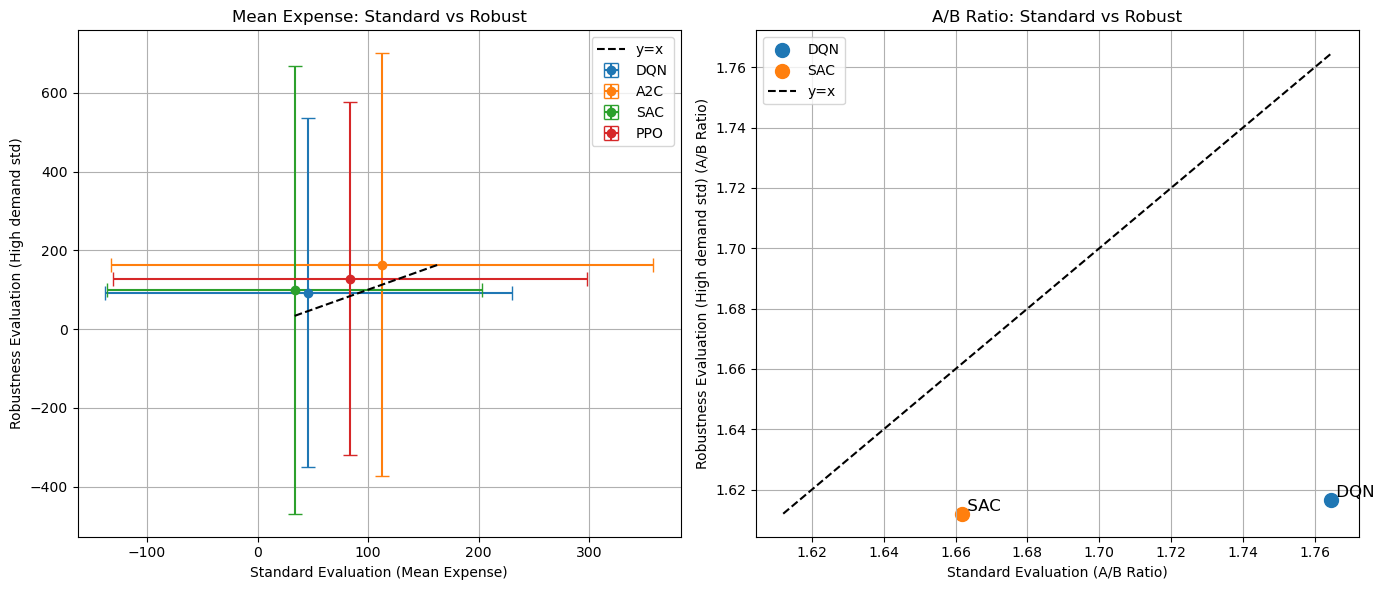

In [37]:
import matplotlib.pyplot as plt
import numpy as np

models = ['DQN', 'A2C', 'SAC', 'PPO']

expense_std = np.array([mean_rewardDQN, mean_rewardA2C, mean_rewardSAC, mean_rewardPPO])
expense_robust = np.array([mean_rewardDQN_robust, mean_rewardA2C_robust, mean_rewardSAC_robust, mean_rewardPPO_robust])
expense_err_std = np.array([std_rewardDQN, std_rewardA2C, std_rewardSAC, std_rewardPPO])
expense_err_robust = np.array([std_rewardDQN_robust, std_rewardA2C_robust, std_rewardSAC_robust, std_rewardPPO_robust])

# 1 figure: 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Mean Expense Comparison
ax = axs[0]
for i, model in enumerate(models):
    ax.errorbar(expense_std[i], expense_robust[i],
                xerr=expense_err_std[i], yerr=expense_err_robust[i],
                fmt='o', capsize=5, label=model)
    
# Identity line for reference
min_val = min(expense_std.min(), expense_robust.min())
max_val = max(expense_std.max(), expense_robust.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='y=x')
ax.set_xlabel('Standard Evaluation (Mean Expense)')
ax.set_ylabel('Robustness Evaluation (High demand std)')
ax.set_title('Mean Expense: Standard vs Robust')
ax.grid()
ax.legend()

# ----- Plot 2: A/B Ratio Comparison -----
models = ['DQN', 'SAC']

# A/B Ratio values
abr_std = np.array([ABRationDQN, ABRationSAC])
abr_robust = np.array([ABRationDQN_robust, ABRationSAC_robust])
ax = axs[1]
for i, model in enumerate(models):
    ax.scatter(abr_std[i], abr_robust[i], s=100, label=model)
    ax.text(abr_std[i], abr_robust[i], f" {model}", fontsize=12, va='bottom', ha='left')

# Plot identity line for A/B Ratio
min_val = min(abr_std.min(), abr_robust.min())
max_val = max(abr_std.max(), abr_robust.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='y=x')
ax.set_xlabel('Standard Evaluation (A/B Ratio)')
ax.set_ylabel('Robustness Evaluation (High demand std) (A/B Ratio)')
ax.set_title('A/B Ratio: Standard vs Robust')
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:


def evaluate_water_level(model, env, n_eval_episodes=1000):
    all_episodes_levels = []  
    for episode in range(n_eval_episodes):
        obs, info = env.reset()
        done = False
        episode_levels = [] 

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)

            episode_levels.append(info['water_level'])
        
        all_episodes_levels.append(episode_levels)
    
    max_steps = max(len(episode) for episode in all_episodes_levels)
    
    avg_water_levels = []
    for step in range(max_steps):
        step_levels = [episode[step] for episode in all_episodes_levels if len(episode) > step]
        avg_water_levels.append(np.mean(step_levels))
    
    return avg_water_levels

def plot_average_water_levels(water_levels_dict):
    plt.figure(figsize=(10, 6))
    
    for model_name, avg_levels in water_levels_dict.items():
        plt.plot(avg_levels, label=model_name)
    
    plt.xlabel("Step")
    plt.ylabel("Average Water Level")
    plt.title("Average Water Level per Step across Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()


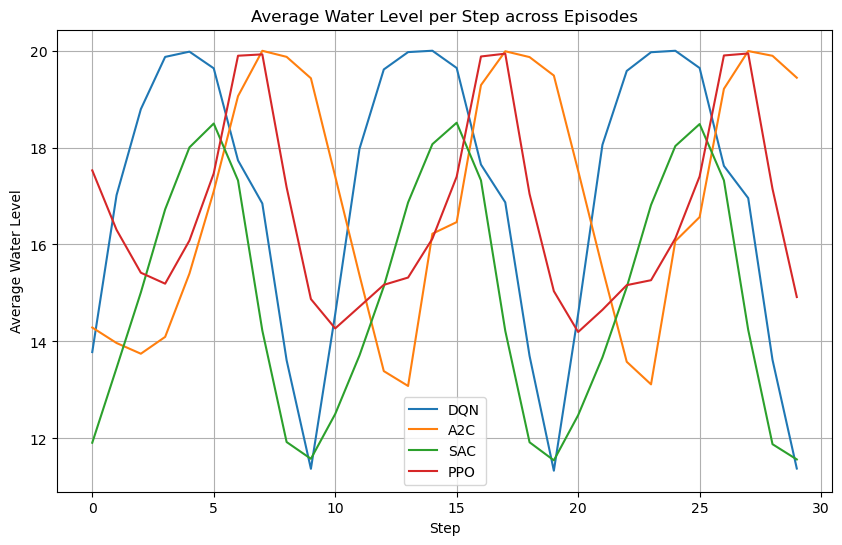

In [39]:
water_levels_by_model = {
    'DQN': evaluate_water_level(modelDQN, envDQN, n_eval_episodes=n_eval_episodes),
    'A2C': evaluate_water_level(modelA2C, envA2C, n_eval_episodes=n_eval_episodes),
    'SAC': evaluate_water_level(modelSAC, envSAC, n_eval_episodes=n_eval_episodes),
    'PPO': evaluate_water_level(modelPPO, envPPO, n_eval_episodes=n_eval_episodes)
}
plot_average_water_levels(water_levels_by_model)
